In [48]:
import pickle
import time
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

### Creating helper functions to run the experiment

In [49]:
# Normalizing the sorted_MX and sorted_MY
def normalize(X):
	# length normalization
	x = X/np.linalg.norm(X, axis = 1).reshape(-1, 1)
	# mean centering each dimension
	x = x - x.mean(axis = 0)
	# length normalizing the mean centered data
	x = x/np.linalg.norm(x, axis = 1).reshape(-1, 1)
	return x

# computing sqaure root of similiarity matrices for both the embedding matrices using svd
def sim_matrix(X, size):
	u, s, _ = np.linalg.svd(X[:size], full_matrices = False)
	return np.dot(u*s, u.T)

def distance_matrix(X1, Y1):
	norm_X1 = np.linalg.norm(X1, axis = 1).reshape(-1,1)**2
	b = np.ones((norm_X1.shape[0], norm_X1.shape[1]+1))
	b[:, :-1] = norm_X1
	norm_X1 = b

	norm_Y1 = np.linalg.norm(Y1, axis = 1).reshape(-1,1)**2
	b = np.ones((norm_Y1.shape[0], norm_Y1.shape[1]+1))
	b[:, 1:] = norm_Y1
	norm_Y1 = b

	dot_p = -2*np.matmul(X1, Y1.T)
	d_matrix = np.matmul(norm_X1, norm_Y1.T) + dot_p
	return d_matrix

def create_idx2word_dict(vocab):
	idx2word = {}
	for i in vocab:
		idx2word[vocab[i]] = i

	return idx2word

def topk_mean(m, k, inplace=False):
	n = m.shape[0]
	ans = np.zeros(n, dtype=m.dtype)
	if k <= 0:
		return ans
	if not inplace:
		m = np.array(m)
	ind0 = np.arange(n)
	ind1 = np.empty(n, dtype=int)
	minimum = m.min()
	for i in range(k):
		m.argmax(axis=1, out=ind1)
		ans += m[ind0, ind1]
		m[ind0, ind1] = minimum
	return ans / k


### Step 0: Load seed dictionary for better initialization

In [50]:
with open('../data/en-hi.txt') as f:
    aligned_words = f.readlines()

### Loading hindi english vocabulary and embedding matrices

In [51]:
hindi_embedding_matrix = pickle.load(open("./hindi_embedding_matrix.pkl", "rb"))
english_embedding_matrix = pickle.load(open("./english_embedding_matrix.pkl", "rb"))
hindi_vocab = pickle.load(open("./hindi_vocab.pkl", "rb"))
english_vocab = pickle.load(open("./english_vocab.pkl", "rb"))

hindi_idx2word = create_idx2word_dict(hindi_vocab)
english_idx2word = create_idx2word_dict(english_vocab)

X = hindi_embedding_matrix
Y = english_embedding_matrix
D = np.zeros((X.shape[0], Y.shape[0]))


for i in aligned_words:
	hindi_word = i.strip().split()[1].strip()
	english_word = i.strip().split()[0].strip()

	if hindi_word in hindi_vocab and english_word in english_vocab:
		D[hindi_vocab[hindi_word], english_vocab[english_word]] = 1


SIM_SIZE = min(X.shape[0], Y.shape[0])

### Step 1: Normalize Embeddings

In [52]:
# normalizing the embeddings
X = normalize(X)
Y = normalize(Y)

### Step 2: Unsupervised Initialization

In [53]:
# similarity matrices
MX = sim_matrix(X, SIM_SIZE)
MY = sim_matrix(Y, SIM_SIZE)

# sorting MX and MY along the rows in order to align them along the j dimension
sorted_MX = np.sort(MX, axis = 1)
sorted_MY = np.sort(MY, axis = 1)

# normalized embeddings for extracting alignment across vocabulary(ith dimension)
X1 = normalize(sorted_MX)
Y1 = normalize(sorted_MY)

### Step 3: Self Learning

In [54]:
# constructing initial solution for the iterative algorithm
sim = X1.dot(Y1.T)
knn_sim_fwd = topk_mean(sim, k = 7)
knn_sim_bwd = topk_mean(sim.T, k = 7)
sim -= knn_sim_fwd[:, np.newaxis]/2 + knn_sim_bwd/2

nearest_neighbors = sim.argmax(axis = 1)
D[range(nearest_neighbors.shape[0]), nearest_neighbors] = 1

# training loop
num_iter = 30
start = time.time()
for i in range(num_iter):
	#computing the optimal orthogonal matrix which maximizes the current dict D
	u, s, vh = np.linalg.svd(np.dot(X.T, np.dot(D, Y)))
	WX = u
	WY = vh

	#computing the optimal dictionary using the similarity matrix of the mapped embeddings
	sim = np.dot(X, WX).dot(np.dot(Y, WY).T)
	knn_sim_fwd = topk_mean(sim, k = 7)
	knn_sim_bwd = topk_mean(sim.T, k = 7)
	sim -= knn_sim_fwd[:, np.newaxis]/2 + knn_sim_bwd/2
    
	nearest_neighbors = sim.argmax(axis = 1)
	D[range(nearest_neighbors.shape[0]), nearest_neighbors] = 1

#final step
u, s, vh = np.linalg.svd(np.dot(X.T, np.dot(D, Y)), full_matrices = False)
s = np.diag(s)
WX = u.dot(np.sqrt(s))
WY = vh.dot(np.sqrt(s))
print("Time for training with csls:", time.time() - start)

#testing
sim = np.dot(X, WX).dot(np.dot(Y, WY).T)
knn_sim_fwd = topk_mean(sim, k = 7)
knn_sim_bwd = topk_mean(sim.T, k = 7)
sim -= knn_sim_fwd[:, np.newaxis]/2 + knn_sim_bwd/2

nearest_neighbors = sim.argmax(axis = 1)

Time for training with csls: 162.58551740646362


In [55]:
embed_X = normalize(np.dot(X, WX))
embed_Y = normalize(np.dot(Y, WY))

print('Saving the embeddings onto transformed space')
with open('en_tform.pkl', 'wb') as f:
    pickle.dump(embed_Y, f)

with open('hi_tform.pkl', 'wb') as f:
    pickle.dump(embed_X, f)

Saving the embeddings onto transformed space


In [46]:
normalize(embed_X)

array([[-8.44328928e-02,  8.71038026e-01, -1.31364320e-01, ...,
        -8.93797235e-07, -3.89613565e-06, -5.43103403e-07],
       [-4.03411047e-01,  5.45980482e-01, -4.77923581e-01, ...,
         6.81481224e-06,  1.94445115e-07,  1.20886575e-05],
       [-7.62161454e-01,  5.18446584e-01, -2.12758610e-01, ...,
         3.68503543e-07, -7.65005926e-07, -1.06128590e-06],
       ...,
       [ 8.41418846e-01,  1.20243442e-01,  2.61985269e-01, ...,
        -5.81698370e-06,  6.39187553e-07,  3.51461376e-08],
       [ 3.26863106e-01, -9.15985702e-01, -1.41844579e-02, ...,
        -2.77441024e-06, -9.62047693e-07, -3.33326252e-07],
       [-2.84899525e-02, -9.55368186e-01, -2.12263052e-01, ...,
        -3.11657928e-07,  1.93479287e-06,  6.82460778e-07]])

In [18]:
for i in range(10):
    print(hindi_idx2word[i], english_idx2word[nearest_neighbors[i]])

कोई fallopian
भी jews
बीमारी lucky
होने grows
पर written
नियमित size
चेकअप looks
कराएँ sins
, safely
लापरवाही kuchh


In [19]:
word_pairs = [
    ['और', 'and'],
    ['उसकी', 'his'],
#     ['उसकी', 'and']
#     ['यहूद', 'were'],
#     ['लेख', 'article'],
]

## Visualisation

/home/zubair/anaconda3/envs/NLP/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/zubair/anaconda3/envs/NLP/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2352 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/zubair/anaconda3/envs/NLP/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 2324 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/zubair/anaconda3/envs/NLP/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 2352 missing from current font.
  font.set_text(s, 0, flags=flags)


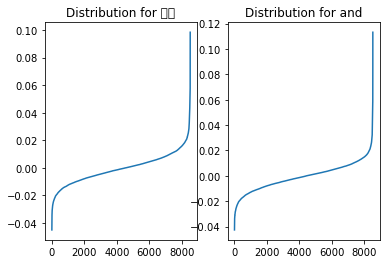

/home/zubair/anaconda3/envs/NLP/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2313 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/zubair/anaconda3/envs/NLP/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2360 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/zubair/anaconda3/envs/NLP/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2325 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/zubair/anaconda3/envs/NLP/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2368 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/zubair/anaconda3/envs/NLP/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 2313 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/zubair/anaconda3/envs/NLP/lib/python3.6/s

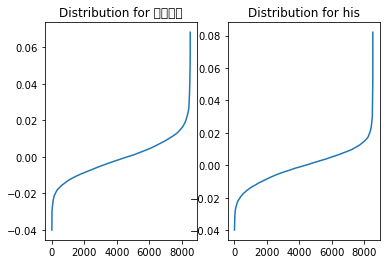

In [20]:
for hi, en in word_pairs:
    hi_index = hindi_vocab[hi]
    en_index = english_vocab[en]
    
    hi_mean = sorted_MX[hi_index]
    en_mean = sorted_MY[en_index]
    
    plt.subplot(1,2,1)
    plt.title('Distribution for {0}'.format(hi))
    plt.plot(hi_mean)
    
    plt.subplot(1,2,2)
    plt.title('Distribution for {0}'.format(en))
    plt.plot(en_mean)
    
    plt.show()

In [31]:
X.shape

(10140, 100)

In [32]:
WX.shape

(100, 100)

In [33]:
Y.shape

(8516, 100)

In [34]:
WY.shape

(100, 100)

## Evaluation
### Intrinsic

In [44]:
cos_sims = []
for hi, en in word_pairs:
    cos_sims.append(np.dot(embed_X[hindi_vocab[hi]], embed_Y[english_vocab[en]].T))
    
cos_sims = np.array(cos_sims)
np.mean(cos_sims)

27.981350492766396

### Extrinsic

In [25]:
import os
from gensim.test.utils import datapath
from gensim.models.wrappers import FastText

model = FastText.load_fasttext_format('en_mod.ft')

analogy_scores = model.wv.evaluate_word_analogies(datapath('questions-words.txt'))
analogy_scores

FileNotFoundError: [Errno 2] No such file or directory: 'en_mod.ft.bin'

In [17]:
english_embedding_matrix[english_vocab['excuse']]+english_embedding_matrix[english_vocab['me']]

array([ 2.3256488 ,  0.50896513, -1.5274669 ,  1.1026577 , -0.05357262,
        0.30393177,  1.4275662 , -0.28244844, -2.9586658 , -0.91595656,
       -0.16583595,  0.7404793 ,  0.7934876 ,  2.2220814 , -1.2631726 ,
        0.6415043 , -0.49462584,  0.47640356,  1.7222499 ,  0.61556995,
       -0.69499385,  0.32218835,  1.7107854 ,  0.83875287,  0.9756324 ,
        0.3989083 , -0.39384377, -0.4930851 ,  2.140209  ,  1.1703581 ,
        0.8674777 , -0.07780394,  0.3114351 , -0.08680315,  0.51912427,
       -1.7254441 ,  0.88654363, -0.15668374, -1.1227112 , -0.46340933,
        1.8575623 ,  0.88171005,  0.71372926,  0.8834495 , -1.5089967 ,
        1.2307827 ,  1.1768324 , -1.4501196 ,  1.9528419 , -0.02040973,
        1.9457443 ,  0.07371062,  1.1193316 , -0.04027185, -0.8409392 ,
        0.81252795, -0.12733603,  2.2777355 ,  0.03757357,  0.36916438,
       -3.083687  ,  0.2645597 ,  0.41451418, -1.0431564 ,  1.0602188 ,
        0.10370865,  0.78076315, -0.35207605,  0.88361394,  2.34

In [18]:
transform_x = np.dot(X, WX)

In [19]:
hindi_idx2word[0]

'कोई'

In [20]:
print(X[0], transform_x[0])

[ 4.63053510e-02 -5.96961677e-02 -6.28718212e-02  4.41755392e-02
 -7.42579475e-02 -2.38388386e-02  4.69245277e-02  3.98744643e-02
 -6.82294443e-02 -1.40330732e-01  9.62985381e-02  7.01462571e-03
  8.07450190e-02 -1.17835335e-01  1.03698783e-01  8.84633213e-02
  1.46564990e-01  3.16890764e-05 -2.18667954e-01 -3.74034904e-02
  7.28726238e-02 -4.61323895e-02 -3.34828421e-02  1.76913273e-02
  8.25952888e-02  2.82757580e-02 -6.27151653e-02  9.91098732e-02
  1.42784053e-02  4.29493561e-02  6.27091751e-02 -2.88868230e-02
 -1.49040958e-02  4.73422520e-02 -8.41436163e-02 -2.93554738e-02
  1.55689970e-01 -9.37642157e-02 -7.35794753e-02 -1.55795485e-01
  6.73232451e-02 -5.97964264e-02 -7.17872530e-02  4.13488187e-02
  1.14327326e-01 -1.11538529e-01  2.30286881e-01  2.01665685e-02
 -1.57701429e-02 -1.71978295e-01  6.90863505e-02  2.33648233e-02
  7.73479715e-02 -9.14351568e-02 -7.95619190e-03 -1.12567239e-01
  1.07732207e-01 -1.39830932e-01  4.06571552e-02 -1.10408552e-02
 -7.38289207e-02  1.29505

In [21]:
np.mean(np.dot(X, WX), axis=0)

array([ 2.53268141e-02, -2.46875027e-02, -1.03053308e-02, -4.33102300e-03,
        2.84499046e-02, -1.47303371e-03, -8.59754233e-03, -1.34157054e-03,
       -2.45689401e-03,  1.27837378e-02,  3.37582172e-03,  1.80821938e-03,
        7.11572564e-03,  5.96658916e-03, -3.31268736e-03, -6.43079492e-03,
       -8.48037235e-04, -4.04037995e-03, -7.79543189e-04,  8.12883330e-04,
       -3.14745946e-03, -2.87734681e-05, -1.30360468e-03, -8.34367772e-04,
       -2.48064667e-04, -1.94386284e-03,  1.74836561e-03, -8.02949885e-04,
        3.80942541e-06,  2.00102257e-04,  1.13167778e-04,  5.86584895e-04,
        9.52285611e-04, -4.02565857e-04, -2.95233454e-04, -3.40593526e-04,
       -4.33428123e-04,  1.06733188e-04,  1.49147800e-04,  1.42887034e-05,
        2.21826520e-04, -4.03443811e-04,  1.14144603e-04,  7.58027649e-05,
        3.23612934e-04, -6.43806637e-05, -5.38926466e-05,  1.55478981e-04,
        3.04452458e-04, -2.78246508e-05,  8.41120436e-05, -1.43804913e-04,
        1.03614716e-04, -

In [22]:
np.mean(np.dot(Y, WY), axis=0)

array([ 9.53943750e-04, -1.78154961e-03, -2.47934412e-03,  9.43307675e-04,
        8.46739705e-04,  1.24643223e-04,  5.35373616e-04,  3.54508953e-03,
       -3.78626546e-03,  4.09086665e-03, -2.85445494e-03,  2.23717580e-03,
        2.49460289e-04,  2.33167034e-03,  4.66165179e-03, -5.12875143e-03,
        1.63629246e-03,  1.78003879e-03,  2.49442395e-03, -1.55153884e-03,
        3.72083531e-03, -1.85375931e-03,  3.03247928e-03, -1.60091444e-03,
       -1.80480401e-03,  2.92442295e-03,  5.16664180e-04, -1.49394487e-04,
        7.84762632e-04,  1.26522839e-03, -1.47206336e-03, -5.47422467e-03,
        1.34815662e-03,  2.40001718e-03,  3.44778956e-03, -2.83883543e-03,
       -1.67438190e-03, -1.79063445e-03, -1.59432928e-03, -2.22953886e-03,
       -2.52675665e-05,  1.47433590e-04,  8.60458718e-03, -2.60803150e-03,
        1.61873961e-03, -2.32969714e-03,  6.36808609e-04,  6.37818066e-04,
        4.21552169e-04, -5.91316448e-05,  4.33058646e-03, -1.46910926e-03,
       -2.18462176e-03, -

In [23]:
for en, hi in pairs:
    

SyntaxError: unexpected EOF while parsing (<ipython-input-23-7694719b603f>, line 2)